# CSE480: Machine Vision — Lab Assignment #05

This notebook contains the full solution for **Lab 05**.

## What we will do in this lab
### Task 1 — CNN from scratch (Fashion-MNIST)
- Build a **shallow Convolutional Neural Network (CNN)** using **Conv2D + MaxPooling2D**.
- Train and test the CNN on **Fashion-MNIST**.
- Plot **training/validation loss** and **training/validation accuracy**.
- Display **sample predictions** with their **true labels**.

### Task 2 — Transfer Learning (CIFAR-10)
- Load a **pre-trained CNN** (e.g., **VGG16**, **ResNet50**, or **MobileNetV2**) using `keras.applications`.
- Use `include_top=False` to remove the original classification head.
- **Freeze** the convolutional base and add a **new classification head** for **CIFAR-10 (10 classes)**.
- Train only the new layers and evaluate the performance.
- Compare the result with **Lab Exercise 1** (Dense-only CIFAR-10) in terms of **accuracy** and **training time**.


## Setup
Install required packages (run once).

## Imports and shared utilities

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers

np.random.seed(42)

def plot_history(history, title_prefix="Model"):
    hist = history.history
    epochs = range(1, len(hist.get("loss", [])) + 1)

    # Loss
    if "loss" in hist:
        plt.figure()
        plt.plot(epochs, hist["loss"], label="train_loss")
        if "val_loss" in hist:
            plt.plot(epochs, hist["val_loss"], label="val_loss")
        plt.title(f"{title_prefix} - Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(True)

    # Accuracy
    acc_key = "accuracy" if "accuracy" in hist else ("acc" if "acc" in hist else None)
    val_acc_key = "val_accuracy" if "val_accuracy" in hist else ("val_acc" if "val_acc" in hist else None)

    if acc_key is not None:
        plt.figure()
        plt.plot(epochs, hist[acc_key], label="train_accuracy")
        if val_acc_key is not None:
            plt.plot(epochs, hist[val_acc_key], label="val_accuracy")
        plt.title(f"{title_prefix} - Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.grid(True)

    plt.show()


def show_sample_predictions(model, x, y_true, class_names, n=12, title="Sample Predictions"):
    idx = np.random.choice(len(x), size=n, replace=False)
    x_s = x[idx]
    y_s = y_true[idx]

    preds = model.predict(x_s, verbose=0)
    y_pred = np.argmax(preds, axis=1)

    cols = 4
    rows = int(np.ceil(n / cols))
    plt.figure(figsize=(12, 3 * rows))
    for i in range(n):
        plt.subplot(rows, cols, i + 1)
        img = x_s[i]
        if img.shape[-1] == 1:
            plt.imshow(img.squeeze(), cmap="gray")
        else:
            plt.imshow(img)
        true_label = class_names[int(y_s[i])]
        pred_label = class_names[int(y_pred[i])]
        color = "green" if y_pred[i] == y_s[i] else "red"
        plt.title(f"Pred: {pred_label}\nTrue: {true_label}", color=color, fontsize=10)
        plt.axis("off")
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()


# Task 1 — CNN on Fashion-MNIST

We will:
1. Load Fashion-MNIST.
2. Normalize pixel values to the range **[0, 1]**.
3. Add a channel dimension so the shape becomes **(28, 28, 1)**.
4. Build a shallow CNN:
   - Conv2D → MaxPooling2D → Conv2D → MaxPooling2D → Flatten → Dense → Softmax
5. Train for **10 epochs** (as recommended).
6. Evaluate on the test set.
7. Plot learning curves and show sample predictions.


In [2]:
def build_fashion_cnn(input_shape=(28, 28, 1), num_classes=10):
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, (3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation="softmax")
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 421,642 (1.61 MB)

 Trainable params: 421,642 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
422/422 - 12s - 29ms/step - accuracy: 0.8024 - loss: 0.5500 - val_accuracy: 0.8657 - val_loss: 0.3646
Epoch 2/10
422/422 - 9s - 22ms/step - accuracy: 0.8736 - loss: 0.3508 - val_accuracy: 0.8858 - val_loss: 0.3040
Epoch 3/10
422/422 - 9s - 21ms/step - accuracy: 0.8921 - loss: 0.2992 - val_accuracy: 0.8940 - val_loss: 0.2874
Epoch 4/10
422/422 - 9s - 21ms/step - accuracy: 0.9017 - loss: 0.2714 - val_accuracy: 0.9062 - val_loss: 0.2528
Epoch 5/10
422/422 - 9s - 21ms/step - accuracy: 0.9108 - loss: 0.2456 - val_accuracy: 0.9117 - val_loss: 0.2462
Epoch 6/10
422/422 - 9s - 22ms/step - accuracy: 0.9161 - loss: 0.2259 - val_accuracy: 0.9143 - val_loss: 0.2344
Epoch 7/10
422/422 - 9s - 22ms/step - accuracy: 0.9222 - loss: 0.2105 - val_accuracy: 0.9187 - val_loss: 0.2282
Epoch 8/10
422/422 - 9s - 21ms/step - accuracy: 0.9270 - loss: 0.1961 - val_accuracy: 0.9177 - val_loss: 0.2247
Epoch 9/10
422/422 - 9s - 20ms/step - accuracy: 0.9321 - loss: 0.1824 - val_accuracy: 0.9190 - val_loss

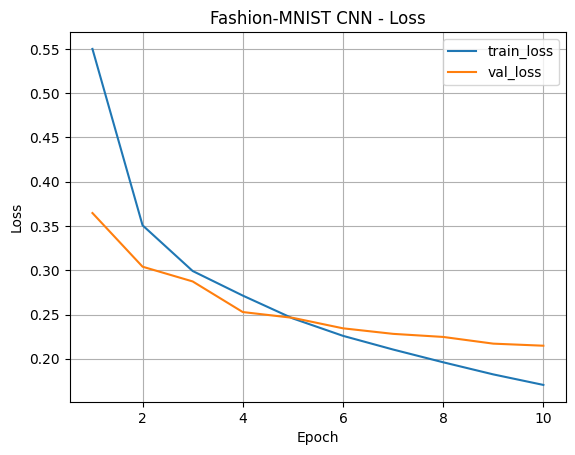

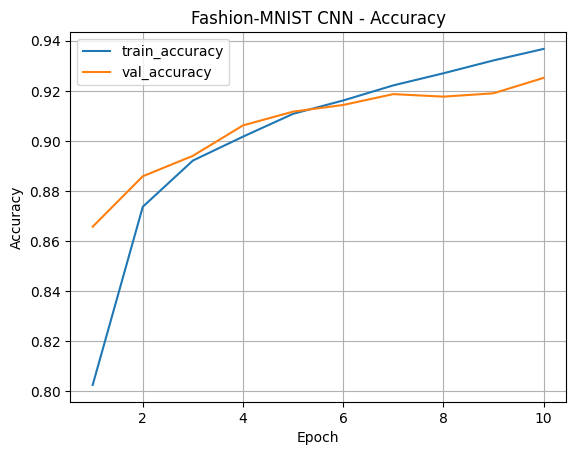

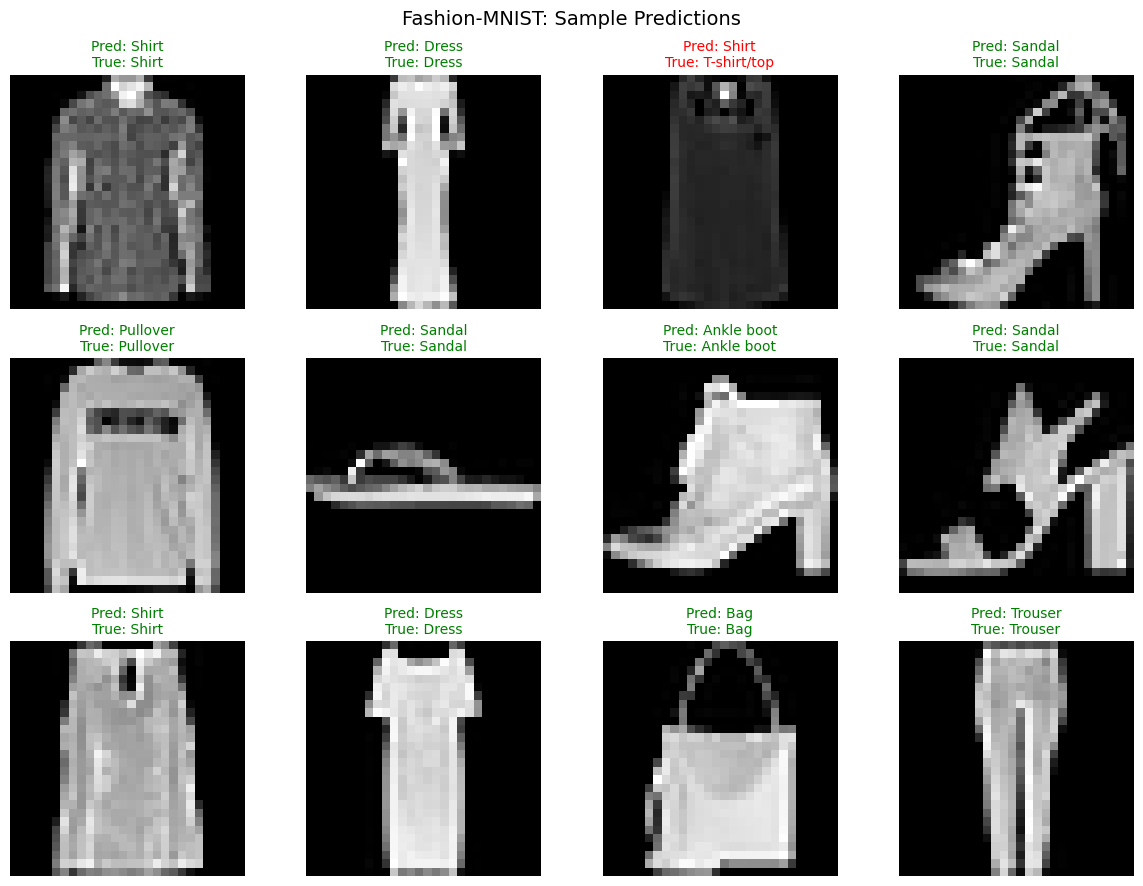

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

# Normalize and add channel dimension
x_train = (x_train.astype("float32") / 255.0)[..., np.newaxis]
x_test  = (x_test.astype("float32") / 255.0)[..., np.newaxis]

class_names_fashion = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

model_fashion = build_fashion_cnn(input_shape=x_train.shape[1:], num_classes=10)
model_fashion.summary()

t0 = time.time()
history_fashion = model_fashion.fit(
    x_train, y_train,
    validation_split=0.1,
    epochs=10,
    batch_size=128,
    verbose=2
)
train_time_fashion = time.time() - t0

test_loss_fashion, test_acc_fashion = model_fashion.evaluate(x_test, y_test, verbose=0)
print(f"[Fashion-MNIST] Test Loss: {test_loss_fashion:.4f} | Test Accuracy: {test_acc_fashion:.4f}")
print(f"[Fashion-MNIST] Training Time: {train_time_fashion:.2f} seconds")

plot_history(history_fashion, title_prefix="Fashion-MNIST CNN")
show_sample_predictions(model_fashion, x_test, y_test, class_names_fashion, n=12, title="Fashion-MNIST: Sample Predictions")


# Task 2 — Transfer Learning on CIFAR-10

We will:
1. Load CIFAR-10.
2. Load a pre-trained CNN **without** the top classification layer using `include_top=False`.
3. Freeze the convolutional base (`base.trainable = False`).
4. Add a new head for **10 CIFAR-10 classes**:
   - GlobalAveragePooling2D → Dense → Dropout → Softmax
5. Train only the new head for **5–10 epochs**.
6. Evaluate and compare with your Dense-only CIFAR-10 from Lab Exercise 1.

**Recommended pre-trained model for speed:** MobileNetV2.


In [4]:
def build_transfer_model(base_name="MobileNetV2", input_shape=(32, 32, 3), num_classes=10):
    if base_name == "VGG16":
        base = keras.applications.VGG16(include_top=False, weights="imagenet", input_shape=input_shape)
        preprocess = keras.applications.vgg16.preprocess_input
    elif base_name == "ResNet50":
        base = keras.applications.ResNet50(include_top=False, weights="imagenet", input_shape=input_shape)
        preprocess = keras.applications.resnet50.preprocess_input
    else:
        base = keras.applications.MobileNetV2(include_top=False, weights="imagenet", input_shape=input_shape)
        preprocess = keras.applications.mobilenet_v2.preprocess_input

    base.trainable = False  # Freeze convolutional base

    inputs = keras.Input(shape=input_shape)
    x = preprocess(inputs)
    x = base(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model


C:\Users\Eng Abdullah Sherif\AppData\Local\Temp\ipykernel_17952\354104835.py:9: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = keras.applications.MobileNetV2(include_top=False, weights="imagenet", input_shape=input_shape)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 1, 1, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,588,490 (9.87 MB)

 Trainable params: 330,506 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/8
352/352 - 18s - 51ms/step - accuracy: 0.2576 - loss: 2.0475 - val_accuracy: 0.2922 - val_loss: 1.9535
Epoch 2/8
352/352 - 13s - 37ms/step - accuracy: 0.2881 - loss: 1.9505 - val_accuracy: 0.2984 - val_loss: 1.9232
Epoch 3/8
352/352 - 14s - 39ms/step - accuracy: 0.2976 - loss: 1.9249 - val_accuracy: 0.3066 - val_loss: 1.9058
Epoch 4/8
352/352 - 13s - 36ms/step - accuracy: 0.3029 - loss: 1.9054 - val_accuracy: 0.3080 - val_loss: 1.9008
Epoch 5/8
352/352 - 13s - 36ms/step - accuracy: 0.3090 - loss: 1.8921 - val_accuracy: 0.3080 - val_loss: 1.8938
Epoch 6/8
352/352 - 13s - 37ms/step - accuracy: 0.3121 - loss: 1.8809 - val_accuracy: 0.3066 - val_loss: 1.8910
Epoch 7/8
352/352 - 14s - 39ms/step - accuracy: 0.3174 - loss: 1.8686 - val_accuracy: 0.3166 - val_loss: 1.8889
Epoch 8/8
352/352 - 13s - 38ms/step - accuracy: 0.3203 - loss: 1.8602 - val_accuracy: 0.3138 - val_loss: 1.8828
[CIFAR-10 Transfer Learning] Test Loss: 1.8932 | Test Accuracy: 0.3086
[CIFAR-10 Transfer Learning] Trai

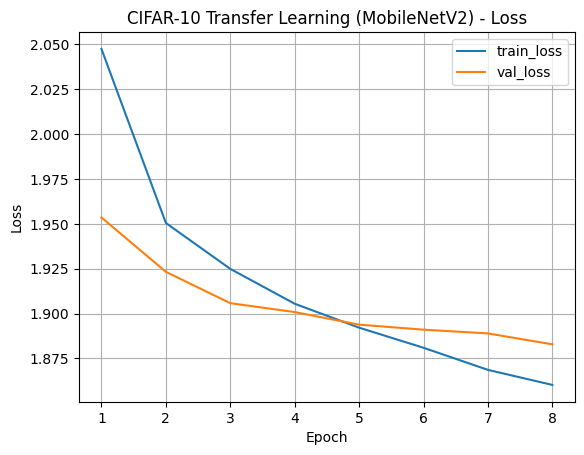

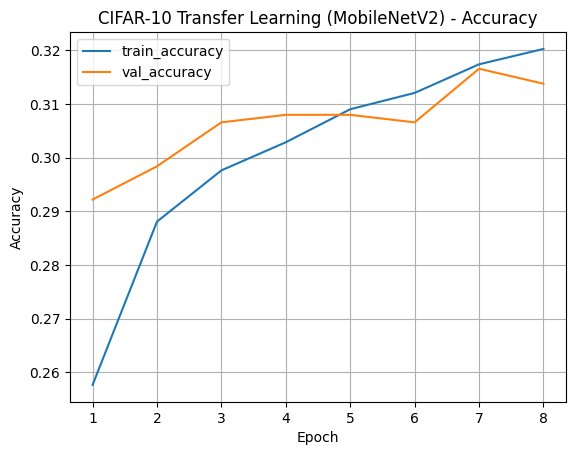

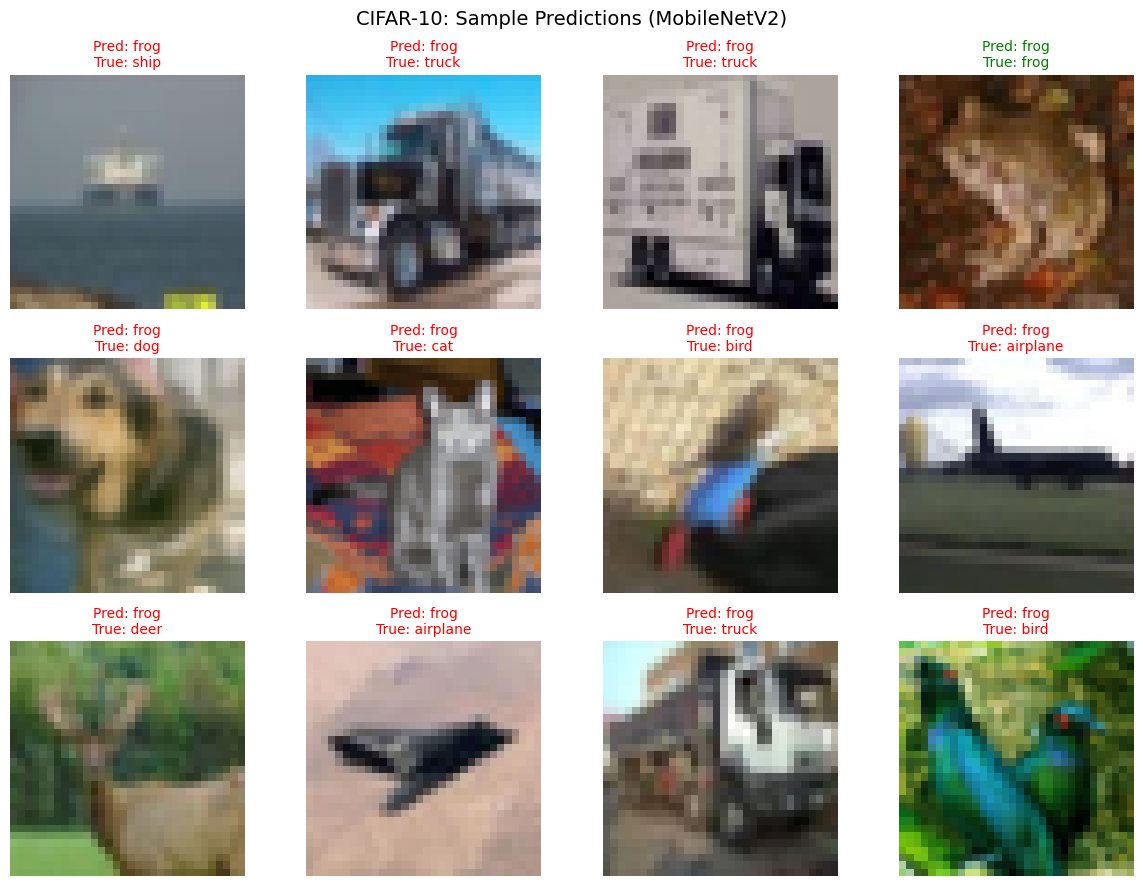

In [5]:
(x_train_c, y_train_c), (x_test_c, y_test_c) = keras.datasets.cifar10.load_data()
y_train_c = y_train_c.squeeze()
y_test_c  = y_test_c.squeeze()

# Keep raw [0..255] float32 and let preprocess_input handle it
x_train_c = x_train_c.astype("float32")
x_test_c  = x_test_c.astype("float32")

class_names_cifar = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

base_name = "MobileNetV2"  # You can change to: 'VGG16' or 'ResNet50'
model_tl = build_transfer_model(base_name=base_name, input_shape=(32, 32, 3), num_classes=10)
model_tl.summary()

t0 = time.time()
history_tl = model_tl.fit(
    x_train_c, y_train_c,
    validation_split=0.1,
    epochs=8,
    batch_size=128,
    verbose=2
)
train_time_tl = time.time() - t0

test_loss_tl, test_acc_tl = model_tl.evaluate(x_test_c, y_test_c, verbose=0)
print(f"[CIFAR-10 Transfer Learning] Test Loss: {test_loss_tl:.4f} | Test Accuracy: {test_acc_tl:.4f}")
print(f"[CIFAR-10 Transfer Learning] Training Time: {train_time_tl:.2f} seconds")

plot_history(history_tl, title_prefix=f"CIFAR-10 Transfer Learning ({base_name})")

# For visualization only, scale to [0,1] (images look normal)
show_sample_predictions(model_tl, x_test_c / 255.0, y_test_c, class_names_cifar, n=12,
                        title=f"CIFAR-10: Sample Predictions ({base_name})")


## Comparison Note (Lab Exercise 1 vs Lab 05 Task 2)

To complete the comparison requirement, report:
- **Accuracy:** Dense-only CIFAR-10 (Lab Exercise 1) vs Transfer Learning (this lab)
- **Training time:** Dense-only vs Transfer Learning

In general, Transfer Learning should give:
- Higher accuracy (often significantly higher)
- Faster convergence (fewer epochs needed)
